In [1]:
import numpy as np

import pandas as pd

import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import gc
import time
import seaborn as sns

SEED=42

In [2]:
def load_traindf():
    traindf = pd.read_csv('../input/landmark-recognition-2021/train.csv')
    traindf['img_path'] = (traindf['id'].apply(lambda r: os.path.join
                            ('../input/landmark-recognition-2021/train', r[0], r[1], r[2], r + '.jpg')))
    
    traindf['landmark_id'] = traindf['landmark_id'].apply(lambda x: np.int32(x))
    
    return traindf
                           
# Reading and resizing images from their path
def img_read_resize(img_path): 
    img = plt.imread(img_path)
    img_redim = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_redim
                    
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [3]:
traindf = load_traindf()
landmark_unique = len(traindf['landmark_id'].unique())
traindf

,id,landmark_id,img_path
0,17660ef415d37059,1,../input/landmark-recognition-2021/train/1/7/6...
1,92b6290d571448f6,1,../input/landmark-recognition-2021/train/9/2/b...
2,cd41bf948edc0340,1,../input/landmark-recognition-2021/train/c/d/4...
3,fb09f1e98c6d2f70,1,../input/landmark-recognition-2021/train/f/b/0...
4,25c9dfc7ea69838d,7,../input/landmark-recognition-2021/train/2/5/c...
...,...,...,...
1580465,72c3b1c367e3d559,203092,../input/landmark-recognition-2021/train/7/2/c...
1580466,7a6a2d9ea92684a6,203092,../input/landmark-recognition-2021/train/7/a/6...
1580467,9401fad4c497e1f9,203092,../input/landmark-recognition-2021/train/9/4/0...
1580468,aacc960c9a228b5f,203092,../input/landmark-recognition-2021/train/a/a/c...


In [4]:
print(traindf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int32 
 2   img_path     1580470 non-null  object
dtypes: int32(1), object(2)
memory usage: 30.1+ MB
None


In [5]:
len(traindf['landmark_id'].value_counts())

81313

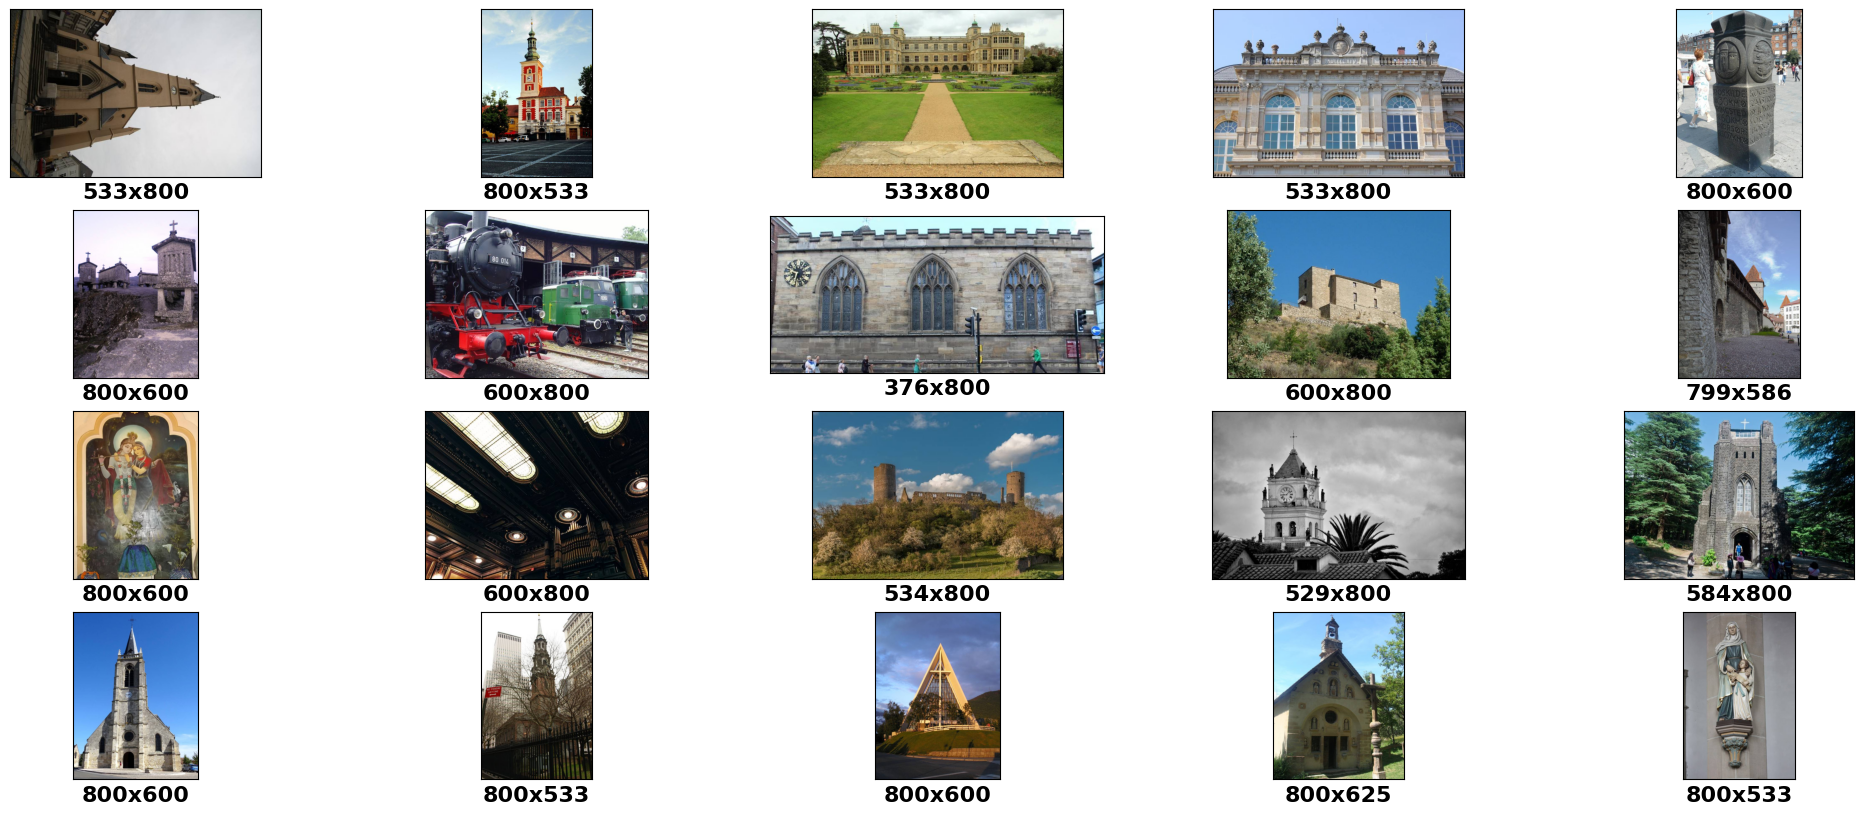

In [6]:
# Set up the figure size for displaying images
plt.figure(figsize=(25, 10))

# Loop to display 20 random images from the dataset
for i in range(20):
    # Select a random index to pick an image
    random_index = np.random.randint(0, traindf.shape[0])
    
    # Read the image from the path
    image_path = traindf['img_path'].iloc[random_index]
    img = plt.imread(image_path)
    
    # Create a subplot grid with 4 rows and 5 columns, place image in (i+1)th position
    plt.subplot(4, 5, i + 1)
    
    # Remove x and y ticks for a cleaner look
    plt.xticks([])
    plt.yticks([])
    
    # Display image dimensions as the x-axis label in bold font
    plt.xlabel(f"{img.shape[0]}x{img.shape[1]}", fontweight="bold", fontsize=16)
    
    # Display the image
    plt.imshow(img)

# Show all images in a grid
plt.show()

In [7]:
import pandas as pd

# Constants
TOP_LABELS = 500                # Define the number of labels to consider based on frequency
SAMPLES_PER_LABEL = 40         # Define the target number of samples per label
MIN_SAMPLES = 30                # Minimum samples to consider for training
SEED = 42                       # Seed for reproducibility

# Step 1: Identify labels with at least MIN_SAMPLES and select the top TOP_LABELS among them
top_labels = (traindf['landmark_id']
              .value_counts()
              .loc[lambda x: x >= MIN_SAMPLES]   # Filter labels with at least MIN_SAMPLES
              .nlargest(TOP_LABELS)
              .index)

# Step 2: Filter the dataframe to include only these selected labels
filtered_df = traindf[traindf['landmark_id'].isin(top_labels)]

# Step 3: Apply undersampling to ensure up to SAMPLES_PER_LABEL per label
balanced_df = (filtered_df.groupby('landmark_id', group_keys=False)
               .apply(lambda x: x.sample(n=min(len(x), SAMPLES_PER_LABEL), random_state=SEED)))

# Step 4: Reset index for clean indexing
balanced_df.reset_index(drop=True, inplace=True)

# Step 5: Display dataset statistics
print('Number of unique labels in the sample:', balanced_df['landmark_id'].nunique())
print('Total number of samples in the sample:', len(balanced_df))
print('\nRepetitions of elements by class in the sample after undersampling:')
print(balanced_df['landmark_id'].value_counts())

Number of unique labels in the sample: 500
Total number of samples in the sample: 20000

Repetitions of elements by class in the sample after undersampling:
landmark_id
27        40
134235    40
139245    40
138982    40
138775    40
          ..
65141     40
65068     40
64792     40
63334     40
202886    40
Name: count, Length: 500, dtype: int64


/tmp/ipykernel_30/4143514034.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), SAMPLES_PER_LABEL), random_state=SEED)))


In [8]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20000 non-null  object
 1   landmark_id  20000 non-null  int32 
 2   img_path     20000 non-null  object
dtypes: int32(1), object(2)
memory usage: 390.8+ KB


In [9]:
balanced_df.to_csv('balanced_df.csv', index=False)

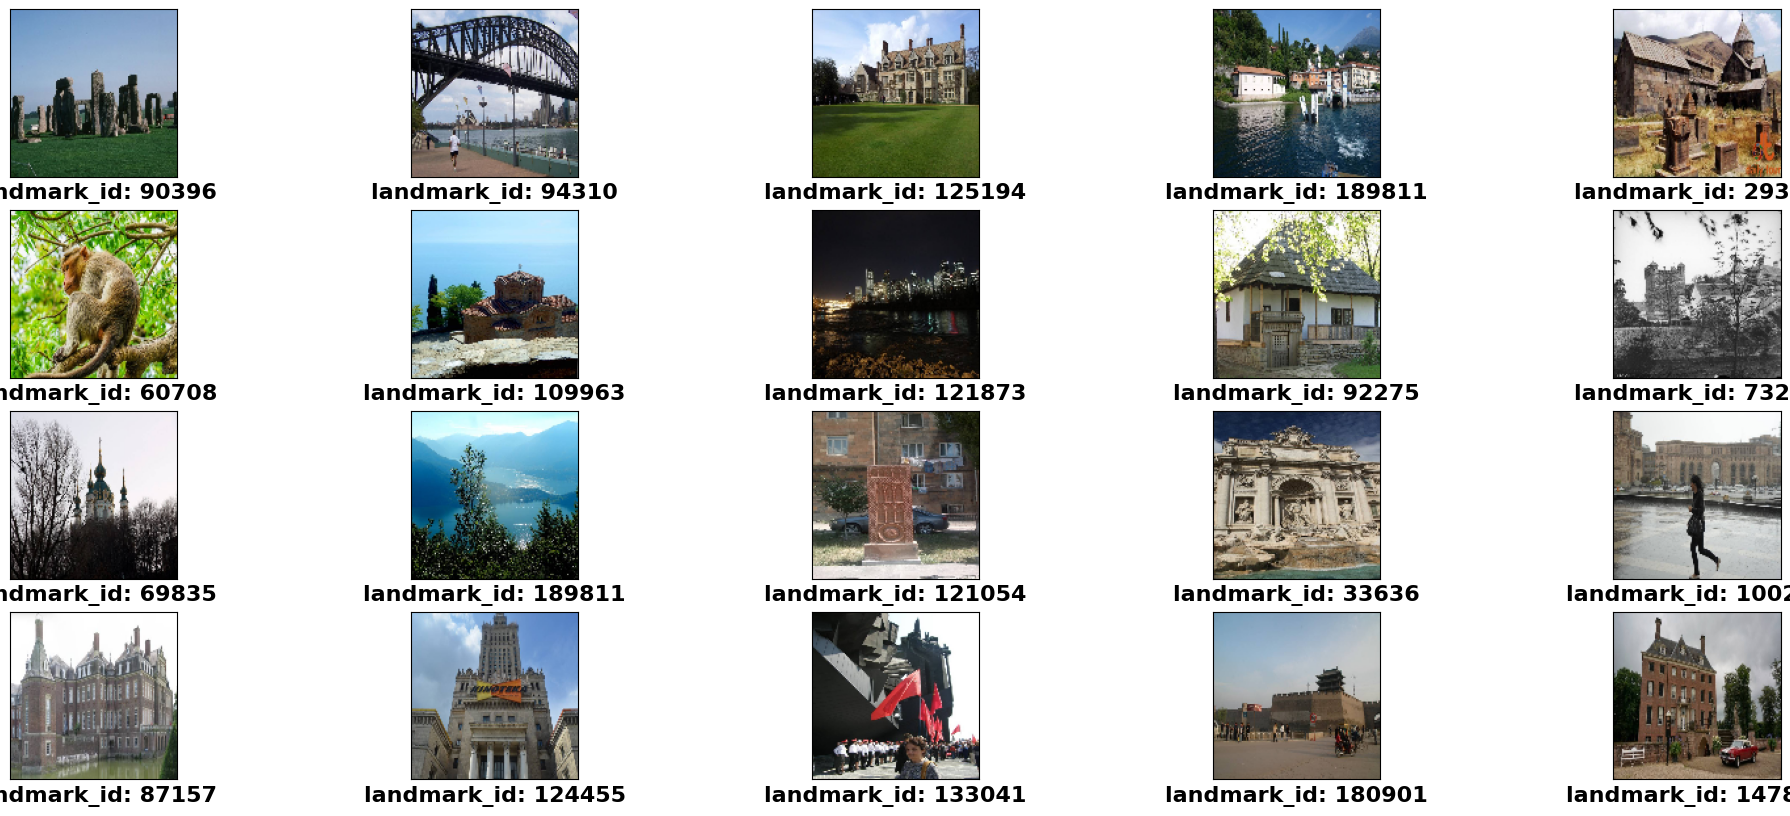

In [10]:
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 128 
# Set up the figure dimensions
plt.figure(figsize=(25, 10))

# Display 20 random images from the dataset
NUM_IMAGES = 20
ROWS, COLS = 4, 5

for i in range(NUM_IMAGES):
    # Select a random index within the bounds of the dataset
    random_index = np.random.randint(0, 20000)
    
    # Load and resize the image at the random index
    img = img_read_resize(balanced_df['img_path'][random_index])
    
    # Create a subplot and remove tick marks
    plt.subplot(ROWS, COLS, i + 1)
    plt.xticks([])
    plt.yticks([])
    
    # Label each image with its landmark_id
    plt.xlabel(f'landmark_id: {balanced_df["landmark_id"][random_index]}', fontweight="bold", fontsize=16)
    
    # Display the image
    plt.imshow(img)

# Show the entire figure
plt.show()

In [11]:
# Initialize lists for storing images and labels
X = []  # Image data
y = []  # Class labels

# Loop through each entry in the filtered dataframe
for idx in range(len(balanced_df)):   
    # Read and resize the image, then add to X
    image = img_read_resize(balanced_df['img_path'][idx])
    X.append(image)
    
    # Append the label to y
    label = balanced_df['landmark_id'][idx]
    y.append(label)            

# Print data types of the variables and elements for verification
print('Variable types: \n')
print(f'X: {type(X)}')
print(f'X elements: {type(X[0])}')
print('\ny:', type(y))
print('y elements:',type(y[0]))

Variable types: 

X: <class 'list'>
X elements: <class 'numpy.ndarray'>

y: <class 'list'>
y elements: <class 'numpy.int32'>


In [12]:
X = np.array(X)
np.save('X.npy', X)  # Save the file

# Download the file
from IPython.display import FileLink
print('Download your file:')
FileLink('X.npy')  # Generates a download link

Download your file:


/kaggle/working/X.npy

In [13]:
np.array(X).shape

(20000, 128, 128, 3)

In [15]:
np.save('Y.npy', y)  # Save the file

# Download the file
from IPython.display import FileLink
print('Download your file:')
FileLink('Y.npy')  # Generates a download link

Download your file:


/kaggle/working/Y.npy